# Face classification

In [22]:
from pathlib import Path
import pickle
from itertools import permutations

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("homework")

from principal_components import load_training_data

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA

In [23]:
data_dir = Path.home() / "data/Faces"

In [24]:
X_train, labs_train, im_shape = load_training_data(data_dir / "fa_L")
X_test, labs_test, _ = load_training_data(data_dir / "fb_L")

In [25]:
labs_train = np.array(labs_train)
labs_test = np.array(labs_test)
classes, counts = np.unique(labs_train, return_counts=True)
pair_classes = classes[counts >= 2]

In [26]:
# Compute pairwise training similarity. 1012 intra_comparisons
intra_compare = []
for c in pair_classes:
    train_ims = np.argwhere(labs_train == c).flatten()
    perms = permutations(train_ims, 2)
    
    intra_compare.extend(list(perms))

In [27]:
extra_compare = []
for c in pair_classes:
    train_ims = np.argwhere(labs_train == c).flatten()
    other_ims = np.argwhere(labs_train != c).flatten()
    for im_idx in train_ims:
        # get 5 random images to compare with
        other_idx = np.random.choice(other_ims, 5)
        for idx in other_idx:
            extra_compare.append((im_idx, idx))

In [28]:
intra_similarities = np.zeros((2*len(intra_compare), X_train.shape[1]), dtype=X_train.dtype)

for idx, (i, j) in enumerate(intra_compare):
    intra_similarities[2*idx] = X_train[i] - X_train[j]
    intra_similarities[2*idx+1] = X_train[j] - X_train[i]  # need the reverse similarity for zero mean

In [29]:
extra_similarities = np.zeros((2*len(extra_compare), X_train.shape[1]), dtype=X_train.dtype)

for idx, (i, j) in enumerate(extra_compare):
    extra_similarities[2*idx] = X_train[i] - X_train[j]
    extra_similarities[2*idx+1] = X_train[j] - X_train[i]  # need the reverse similarity for zero mean

In [30]:
# Y = ["Intra"] * intra_similarities.shape[0]
# Y.extend(["Extra"] * extra_similarities.shape[0])

In [31]:
Y = np.zeros(intra_similarities.shape[0] + extra_similarities.shape[0])
Y[:intra_similarities.shape[0]] = 1

### Intra vs. Extra Face Classification

Training:

1. Compute intra and extra similarities
    $\Delta_I = I_i - I_j, \quad I_i, I_j \in \omega_c,$
    $\Delta_E = I_i - I_j, \quad I_i, I_j \notin \omega_c$.
2. Calculate Singular Value Decomposition and get two sets of orthogonal eigenvectors and singular values $U_I, S_I,$ and $U_E, S_E$.
3. Threshold each set of principal components $n_I, n_E$ to contain 90% of the variance.
4. "Whiten" at least one training image of each person $\hat x$ into the intra and extra space $\hat x_I = U_{I,n_I} S^{-1}_{I, n_I}$. 
5. Precompute bias discriminant term $b_I = -\frac{1}{2} \log | \Sigma_I | = -\frac{1}{2} \sum^{n_I}_i S^2_{I, i}$.

Testing:

1. Given a testing image $x$, whiten into the intra and extra spaces $x_I = U_{I,n_I} S^{-1}_{I, n_I} x$.
2. Compare whitened test image with each whitened training image pair $\Delta_I = x_I - \hat x_I = U_{I,n_I} S^{-1}_{I, n_I} x - U_{I,n_I} S^{-1}_{I, n_I} \hat x = U_{I,n_I} S^{-1}_{I, n_I} (x - \hat x)$.
3. Compute each discriminant $g_I(\Delta_I) = -\frac{1}{2} \Delta_I^T \Delta_I + b_I$.
4. If $g_I(\Delta_I) > g_E(\Delta_E)$, then we found a match!

In [45]:
_, s_I, u_I = np.linalg.svd(intra_similarities/255)

In [46]:
_, s_E, u_E = np.linalg.svd(extra_similarities/255)

In [47]:
n_I = np.argmax(s_I.cumsum() / s_I.sum() > .9)

In [48]:
n_E = np.argmax(s_E.cumsum() / s_E.sum() > .9)

In [49]:
# Precompute discriminant bias terms
bias_I = -.5 * np.square(s_I[:n_I]).sum()
bias_E = -.5 * np.square(s_E[:n_E]).sum()

In [50]:
bias_I - bias_E

12569.333594824238

In [51]:
# Get unique values
cls_unique = np.array([np.argmax(labs_train == c) for c in classes])
X_train_unique = X_train[cls_unique]

In [52]:
# Whiten training samples
X_E_whiten = (np.diag(1/s_E[:n_E]) @ u_E[:n_E] @ X_train_unique.T).T
X_I_whiten = (np.diag(1/s_I[:n_I]) @ u_I[:n_I] @ X_train_unique.T).T

In [53]:
# Test
i = 0
m = X_test.shape[0]
qda_andrew_n = np.zeros((m, 50))

for i in range(m):
    true_idx = np.where(labs_test[i] == classes)[0][0]

    test = X_test[i] / 255
    test_E = (np.diag(1/s_E[:n_E]) @ u_E[:n_E] @ test.T).T
    test_I = (np.diag(1/s_I[:n_I]) @ u_I[:n_I] @ test.T).T

    # Compute similarities
    delta_I = test_I - X_I_whiten
    delta_E = test_E - X_E_whiten

    # Compute discriminants
    g_I = - .5 * np.sum(delta_I * delta_I, axis=1)
    g_E =  - .5 * np.sum(delta_E * delta_E, axis=1)

    # Top 50 matches
    matches_50 = (g_E - g_I).argsort()[:50]
    for j in range(50):
        if matches_50[j] == true_idx:
            qda_andrew_n[i, j:] = 1
            break

In [54]:
qda_andrew_score = qda_andrew_n.mean(axis=0)

In [55]:
qda_andrew_score

array([0.00083612, 0.00167224, 0.00250836, 0.00334448, 0.0041806 ,
       0.00501672, 0.00668896, 0.00752508, 0.0083612 , 0.01003344,
       0.01170569, 0.01254181, 0.01337793, 0.01421405, 0.01588629,
       0.01588629, 0.01672241, 0.01755853, 0.01839465, 0.02006689,
       0.02006689, 0.02090301, 0.02173913, 0.02257525, 0.02341137,
       0.02424749, 0.02508361, 0.02591973, 0.02675585, 0.02759197,
       0.03010033, 0.03093645, 0.03177258, 0.03344482, 0.03344482,
       0.03428094, 0.03511706, 0.0367893 , 0.03762542, 0.03929766,
       0.04013378, 0.0409699 , 0.0409699 , 0.04180602, 0.04264214,
       0.04347826, 0.04431438, 0.0451505 , 0.04598662, 0.04682274])

In [61]:
qda = QDA()
qda.fit(np.vstack([intra_similarities/255, extra_similarities/255]), Y)

QuadraticDiscriminantAnalysis()

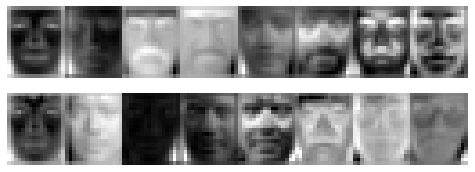

In [63]:
# Plot the dual eigenfaces
aspect = im_shape[0] / im_shape[1]

fig, axs = plt.subplots(2, 8, figsize=(8 / aspect, 2 + .4))

for i in range(8):
    interface = qda.rotations_[0][:, i].reshape(im_shape)
    extraface = qda.rotations_[1][:, i].reshape(im_shape)
    # Find two pictures in train and test set for each label
    axs[0, i].imshow(interface)
    axs[1, i].imshow(extraface)
    axs[0, i].axis("off")
    axs[1, i].axis("off")

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

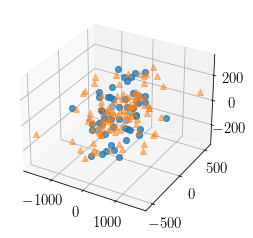

In [65]:
ax = plt.subplot(projection='3d')

proj_intra = intra_similarities @ qda.rotations_[0][:, :3]
proj_extra = extra_similarities @ qda.rotations_[1][:, :3]

ax.plot(proj_intra[:100, 0], proj_intra[:100, 1], proj_intra[:100, 2], "o", alpha=0.5)
ax.plot(proj_extra[:100, 0], proj_extra[:100, 1], proj_extra[:100, 2], "^", alpha=0.5);

In [67]:
# Compare angles between eigenvectors
u_inter = qda.rotations_[0].T
u_extra = qda.rotations_[1].T
print("Angles between first 20 eigenvectors of intra and extra distributions")
angles = np.arccos(np.sum(u_inter[:20] * u_extra[:20], axis=1)) * 180 / np.pi
print(np.array2string(angles, precision=2))

Angles between first 20 eigenvectors of intra and extra distributions
[  8.7  167.44 123.38  89.57  91.09  71.73 117.7   87.54  35.42 103.38
  90.31  92.2  107.04  79.89  85.91 101.35  75.56 118.13  98.63 130.03]


In [90]:
# Compare one test image
i = 0
m = X_test.shape[0]

n_matches = np.zeros((m, 50))

for i in range(m):
    test = X_test[i]
    truth = labs_test[i]

    X_sim = (test - X_train)/255
    score = qda.decision_function(X_sim)
    matches_50 = np.argsort(-score)[:50]
    for j, match in enumerate(matches_50):
        if labs_train[match] == truth:
            n_matches[i, j:] = 1
            break

In [91]:
quadratic_query_score = n_matches.mean(axis=0)

In [92]:
# Compare with LDA
lda = LDA()
X_train_transformed = lda.fit_transform(X_train/255, labs_train)
X_test_transformed = lda.transform(X_test/255)

In [93]:
# amount of information each singular value adds
thresholds = [.99]

variances = lda.explained_variance_ratio_
information_k = np.cumsum(variances) / np.sum(variances)
k = [np.argmax(information_k > thresh) for thresh in thresholds]

cmc = np.zeros((X_test_transformed.shape[0], len(k), 50), dtype=np.bool)
for i, (test, label) in enumerate(zip(X_test_transformed, labs_test)):
    # test = X_test_transformed[0]
    # label = labs_test[0]
    for j, k_i in enumerate(k):
# k_i = k[0]

        error = test - X_train_transformed
        norm_error = np.linalg.norm(error[:, :k_i], axis=1)
        n_matches = [labs_train[train_idx] for train_idx in np.argsort(norm_error)[:51]]
        cmc[i,j] = np.array([label in n_matches[:n] for n in range(1,51)])

lda_query_score = cmc.mean(axis=0)


In [94]:
# Just do Vanilla PCA
from sklearn.decomposition import PCA

In [95]:
pca = PCA(n_components=130)

In [96]:
x_train_pca = pca.fit_transform(X_train/255)

In [97]:
x_test_pca = pca.transform(X_test/255)

In [98]:
sig_inv = 1 / (pca.singular_values_**2)

In [99]:
pca_n = np.zeros((m, 50))

for i in range(m):
    test = x_test_pca[i]
    test_lab = labs_test[i]

    delta = test - x_train_pca
    dist = np.sum(delta * sig_inv * delta, axis=1)
    matches_50 = dist.argsort()

    lab_matches = [labs_train[idx] for idx in matches_50]
    for j, lab in enumerate(lab_matches):
        if lab == test_lab:
            pca_n[i, j:] = 1

pca_score = pca_n.mean(axis=0)    


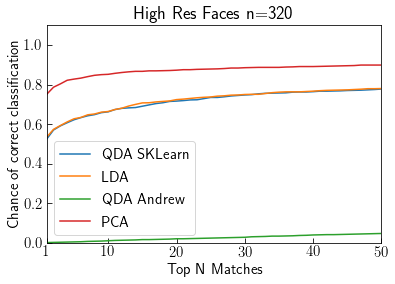

In [100]:
fig, ax_curve = plt.subplots()
ax_curve.plot(range(1, 51), quadratic_query_score, label="QDA SKLearn")
ax_curve.plot(range(1, 51), lda_query_score.flatten(), label="LDA")
ax_curve.plot(range(1, 51), qda_andrew_score, label="QDA Andrew")
ax_curve.plot(range(1, 51), pca_score, label="PCA")


ax_curve.set_xlabel("Top N Matches")
ax_curve.set_ylabel("Chance of correct classification")
ax_curve.set_title(f"High Res Faces n={im_shape[0] * im_shape[1]}")
ax_curve.set_ylim(0, 1.1)
ax_curve.set_xlim(1, 50)
ax_curve.set_xticks([1, 10, 20, 30, 40, 50])
ax_curve.legend();

In [88]:
match_idx, count = np.unique(n_matches, return_counts=True)

In [89]:
np.cumsum(count) / count.sum()

array([0.03921569, 0.05882353, 0.07843137, 0.1372549 , 0.25490196,
       0.2745098 , 0.29411765, 0.33333333, 0.35294118, 0.37254902,
       0.39215686, 0.41176471, 0.43137255, 0.45098039, 0.49019608,
       0.50980392, 0.56862745, 0.58823529, 0.64705882, 0.7254902 ,
       0.74509804, 0.80392157, 0.8627451 , 0.90196078, 0.96078431,
       0.98039216, 1.        ])